In [323]:
# libs need for project

#numpy
import numpy as np
#scipy
import scipy as sp
#matplotlib
import matplotlib.pyplot as plt
#Pillow import all
from PIL import Image


#sci-kit learn
import sklearn as sk
#sci-kit image
import skimage as ski
#pytorch and tensor flow
import torch
import tensorflow as tf
import os

# import cv2
import cv2

In [324]:
from numpy.fft import fft2, fftshift, ifft2

def frequency_analysis(image):
    # Apply Fourier Transform
    f_transform = fft2(image)
    f_shift = fftshift(f_transform)

    # Magnitude Spectrum
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)

    return magnitude_spectrum


In [325]:
def local_std_deviation(image, kernel_size=3): # use kernel 3 for detail and 7 for smooth

    # Calculate local standard deviation
    local_mean = cv2.blur(image, (kernel_size, kernel_size))
    local_mean_sq = cv2.blur(np.square(image), (kernel_size, kernel_size))
    local_std = np.sqrt(local_mean_sq - np.square(local_mean))

    return local_std

In [326]:
def estimate_noise(image):
    # Ensure the image is grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Compute the Laplacian (2nd derivative) of the image
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # The variance of the Laplacian is a good estimator for noise
    return np.sqrt(np.var(laplacian))

In [327]:
def quantify_noise(noise_map):
    total_pixels = noise_map.size
    noise_pixels = np.sum(noise_map)
    noise_percentage = (noise_pixels / total_pixels) * 100
    return noise_percentage

In [328]:
from skimage.metrics import structural_similarity

def calculate_metrics(original, denoised):
    # Calculate PSNR, specifying the range of pixel values
    data_range = original.max() - original.min()  # If range is not standard, calculate from images
    # Calculate SSIM
    ssim = structural_similarity(original, denoised, data_range=data_range)
    # the higehr it is the better the denoised images is but we need to be aware of over blurring

    return ssim


In [329]:
def adaptive_threshold_detection(image, scale_factor=0.5):
    # Convert to grayscale if not already
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Calculate local standard deviation and adaptive threshold
    local_std = local_std_deviation(image)
    adaptive_threshold = local_std / np.mean(local_std) * scale_factor

    # Perform frequency analysis and calculate noise
    magnitude_spectrum = frequency_analysis(image)
    # we do the division to normalize the magnitude_spectrum
    noise = np.divide(magnitude_spectrum, local_std, out=np.zeros_like(magnitude_spectrum), where=local_std!=0)
    noise = (noise > adaptive_threshold).astype(int) # Thresholding that we set it to 1 if the noise is greater than the threshold
    # and 0 otherwise

    return noise

In [330]:
# from the result of the noise level assessment (noise map), we can determine the level of noise in the image and apply the appropriate noise reduction technique
# function to denoising the image

def denoise_image(image, noise_map, sigma_color=75, sigma_space=75):
    # Compute the mean noise of the image
    mean_noise = np.mean(noise_map)

    # Adjust the filter parameters based on mean noise
    adjusted_sigma_color = sigma_color * mean_noise
    adjusted_sigma_space = sigma_space * mean_noise

    # Apply bilateral filter to the entire image
    denoised_image = cv2.bilateralFilter(image, d=-1, sigmaColor=adjusted_sigma_color, sigmaSpace=adjusted_sigma_space)

    return denoised_image


In [331]:
def denoise_color_image(color_image, noise_map, sigma_color=75, sigma_space=75):
    # Split the color image into its component channels
    b, g, r = cv2.split(color_image)

    # Denoise each channel using the noise map
    denoised_b = denoise_image(b, noise_map, sigma_color, sigma_space)
    denoised_g = denoise_image(g, noise_map, sigma_color, sigma_space)
    denoised_r = denoise_image(r, noise_map, sigma_color, sigma_space)

    # Merge the channels back together
    denoised_color_image = cv2.merge((denoised_b, denoised_g, denoised_r))

    return denoised_color_image


In [332]:
# do adaptive histogram equalization to improve the contrast and brightness of the image

def adaptive_histogram_equalization(image, contrastThreshold, gridSize):

    # Convert to grayscale if not already
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image
    assert img is not None, "file could not be read, check with os.path.exists()"

    # Create a CLAHE object (higher contrastThreshold means higher contrast variability)
    clahe = cv2.createCLAHE(contrastThreshold, gridSize)
    cl1 = clahe.apply(img)
    return cl1

In [333]:
# do edge detection to detect any scratches or defects on the image
def edge_detection(image, lowerThreshold, upperThreshold):
  # Convert to grayscale if not already
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image
    assert img is not None, "file could not be read, check with os.path.exists()"

  # Get edges using Canny edge detection, adjust threshold bounds as needed
    edges = cv2.Canny(img,lowerThreshold,upperThreshold)
    return edges


In [334]:
import cv2
import numpy as np

def fill_holes(edge_mask, max_distance=10):
    # Create a copy of the edge mask
    filled_mask = edge_mask.copy()

    # Find coordinates of edge points
    edge_points = np.argwhere(edge_mask > 0)

    # Iterate over edge points
    for point in edge_points:
        # Find nearby points within the specified distance
        nearby_points = np.argwhere(np.linalg.norm(edge_points - point, axis=1) < max_distance)

        # Fill the nearby points
        filled_mask[tuple(edge_points[nearby_points].T)] = 255

    return filled_mask


In [335]:
def detect_scratches(image, lower_threshold_ratio=0.5, upper_threshold_ratio=1.0):
    # Convert image to grayscale if not already
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Adaptive thresholding using Otsu's method
    high_thresh, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = high_thresh * lower_threshold_ratio
    upper_thresh = high_thresh * upper_threshold_ratio

    # Detect edges
    edges = cv2.Canny(image, low_thresh, upper_thresh)

    # Dynamically adjust kernel size based on image size for morphological operations
    kernel_size = max(3, min(image.shape[0], image.shape[1]) // 100)
    morph_kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Perform morphological closing to bridge gaps in scratches
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, morph_kernel)

    # Remove small objects that are not likely to be scratches
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    # Generate scratch mask by thresholding the closed edges
    _, scratch_mask = cv2.threshold(opening, 0, 255, cv2.THRESH_BINARY)

    return scratch_mask

In [336]:
def inpaint_scratches(image, scratch_mask):
    # Calculate radius for inpainting, not based on scratch density but on image resolution
    radius = max(3, min(image.shape[0], image.shape[1]) // 100)

    # Perform inpainting
    inpainted_image = cv2.inpaint(image, scratch_mask, radius, cv2.INPAINT_TELEA)

    return inpainted_image


In [337]:
def gamma_correction(image, gamma=1.0):
    # Gamma correction is a process for adjusting the brightness of an image
    # by using a non-linear transformation between the input values and the mapped output values

    # The 'gamma' value is a parameter of this transformation, and it controls the level of correction

    # If gamma < 1, the image will be darker; if gamma > 1, the image will be brighter

    # Calculate the inverse of gamma
    inv_gamma = 1.0 / gamma

    # Create a lookup table for the gamma correction
    # This table maps each pixel value [0, 255] to a new value based on the gamma correction formula
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    # Apply gamma correction to the image using the lookup table
    # cv2.LUT is a function that maps an array of pixel values (image) to another array of values (table)
    corrected_image = cv2.LUT(image, table)

    # Return the gamma corrected image
    return corrected_image

In [338]:
def histogram_based_tonemap(image):
    # Ensure image is in the float32 format
    if image.dtype != np.float32:
        image = np.float32(image) / 255.0

    # Check if the image is grayscale
    if len(image.shape) == 2:
        # Convert grayscale to 3-channel image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Create tonemap using Drago's method
    tonemap = cv2.createTonemapDrago(1.0, 0.7)

    # Apply tone mapping
    tonemapped_image = tonemap.process(image)

    # Normalize the tonemapped image to lie within the valid range
    normalized_image = cv2.normalize(tonemapped_image, None, 0, 1, cv2.NORM_MINMAX)

    # Convert the normalized image back to 8-bit format
    final_image = (normalized_image * 255).astype('uint8')

    return final_image


In [339]:
def histogram_stretching(image):
    # Split into color channels
    b, g, r = cv2.split(image)

    # Apply histogram stretching to each channel
    b_stretched = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX)
    g_stretched = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX)
    r_stretched = cv2.normalize(r, None, 0, 255, cv2.NORM_MINMAX)

    # Merge channels back
    img_stretched = cv2.merge((b_stretched, g_stretched, r_stretched))

    return img_stretched


In [340]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Use a Gaussian filter to blur the image
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)

    # Calculate the sharpened image
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)

    return sharpened


In [341]:
# Image Sharpening to improve the sharpness of the image or reduce the blurriness of the image
def sharpen(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the Laplacian of the image and then return the variance
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    # If the variance is below a threshold, the image is likely blurry
    if laplacian_var < 10:  # Threshold value, may need to be adjusted or we need new algo taht can detect the blurriness
        # Apply unsharp mask
        sharpened = unsharp_mask(image, sigma=2.0, strength=3.5)
        return sharpened
    else:
        # Image is already sharp or the blurriness is within acceptable range
        return image


In [342]:
# Color Restoration, Correction and Enhancement to improve the color of the image if it is faded or discolored
def color_restoration(image):
    # 1st, use gamme correction to adjust the brightness of the image
    corrected_image = gamma_correction(image, gamma=1.5)

    # then apply histogram stretching to improve the contrast of the image
    stretched_image = histogram_stretching(corrected_image)

    # finally, apply histogram-based tonemapping to enhance the color of the image
    tonemapped_image = histogram_based_tonemap(stretched_image)

    return tonemapped_image

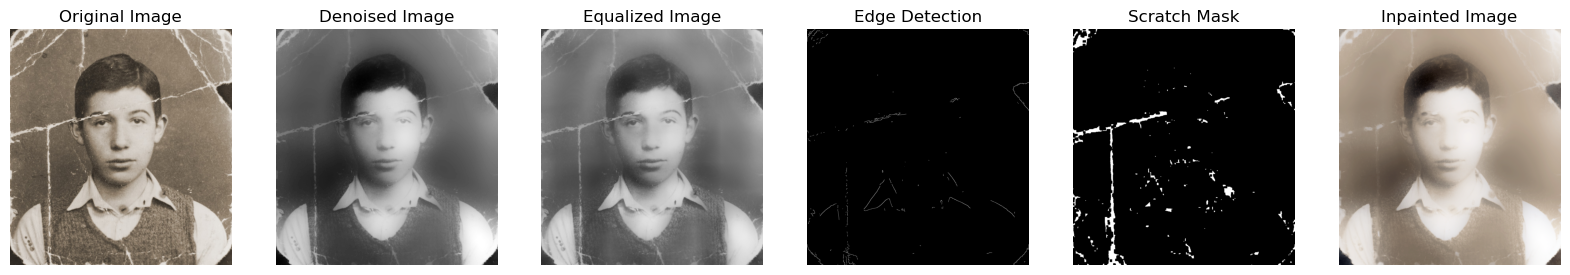

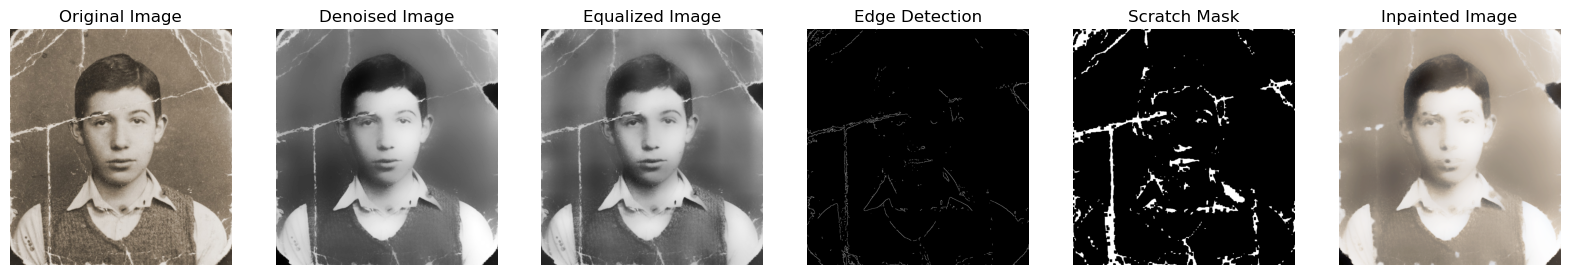

KeyboardInterrupt: 

In [350]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image in color and grayscale

#color_img = cv2.imread('3785cc56082559.Y3JvcCwxMDM2LDgxMCwxMzMsMjA.jpg', cv2.IMREAD_COLOR)
color_img = cv2.imread('746067.jpeg', cv2.IMREAD_COLOR)
# color_img = cv2.imread('2013_11_4_7_001-0.jpg', cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

if color_img is None or gray_img is None:
    raise FileNotFoundError("The specified image path does not exist.")

scale_factors = [1, 10, 50, 80, 100, 150, 200]
for scale in scale_factors:
    # Perform processing on the grayscale image
    noise_map = adaptive_threshold_detection(gray_img, scale_factor=scale)
    denoised_gray = denoise_image(gray_img, noise_map)

    equalized_gray = adaptive_histogram_equalization(denoised_gray, 2.0, (8,8))
    edges = edge_detection(equalized_gray, 150, 200)

    # detect scratches on the image
    scratch_mask = detect_scratches(equalized_gray, lower_threshold_ratio=0.5, upper_threshold_ratio=1.0)
    # fill the holes in the scratch mask
    filled_scratch_mask = fill_holes(scratch_mask)

    # Convert the grayscale results back to BGR for color processing (if necessary)
    equalized_color = cv2.cvtColor(equalized_gray, cv2.COLOR_GRAY2BGR)

    # Apply the same transformations or use the insights on the color image
    denoised_color = denoise_color_image(color_img, noise_map, sigma_color=75, sigma_space=75)
    # call the color restoration function
    tonemapped = color_restoration(denoised_color)
    # sharpen the image
    sharpened = sharpen(tonemapped)
    # inpaint the scratches
    inpainted = inpaint_scratches(sharpened, filled_scratch_mask)


    # Calculate metrics based on the grayscale processing
    # original = gray_img.astype(np.float32)
    # denoised = denoised_gray.astype(np.float32)
    # ssim = calculate_metrics(original, denoised)
    # print(f"Scale Factor: {scale}, SSIM: {ssim}")

    # Visualization
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))  # Original color image
    axes[1].imshow(denoised_gray, cmap='gray')  # Denoised grayscale image
    axes[2].imshow(cv2.cvtColor(equalized_color, cv2.COLOR_BGR2RGB))  # Equalized color image
    axes[3].imshow(edges, cmap='gray')  # Edge detection result
    axes[4].imshow(filled_scratch_mask, cmap='gray')  # Scratch mask
    axes[5].imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))  # Inpainted color image

    for ax in axes:
        ax.axis('off')
        # set the title of the image
    axes[0].set_title("Original Image")
    axes[1].set_title("Denoised Image")
    axes[2].set_title("Equalized Image")
    axes[3].set_title("Edge Detection")
    axes[4].set_title("Scratch Mask")
    axes[5].set_title("Inpainted Image")


    plt.show()

In [344]:
"""import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image in color and grayscale

#color_img = cv2.imread('3785cc56082559.Y3JvcCwxMDM2LDgxMCwxMzMsMjA.jpg', cv2.IMREAD_COLOR)
color_img = cv2.imread('746067.jpeg', cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

if color_img is None or gray_img is None:
    raise FileNotFoundError("The specified image path does not exist.")

scale_factors = [1, 10, 50, 80, 100, 150, 200]
for scale in scale_factors:
    # Perform processing on the grayscale image
    noise_map = adaptive_threshold_detection(gray_img, scale_factor=scale)
    denoised_gray = denoise_image(gray_img, noise_map)

    equalized_gray = adaptive_histogram_equalization(denoised_gray, 2.0, (8,8))
    edges = edge_detection(equalized_gray, 150, 200)
    
    # Detect scratches on the image
    scratch_mask = detect_scratches(equalized_gray, 0.5, 1.0)
    # Fill holes in the scratch mask
    filled_mask = fill_holes(scratch_mask)
    # Inpaint the scratches
    painted = inpaint_scratches(color_img, filled_mask)

    # now, we need to apply the same transformations to the color image


    # Apply the same transformations or use the insights on the color image
    # denoised_color = denoise_color_image(color_img, noise_map, sigma_color=75, sigma_space=75)
    # call the color restoration function
    # tonemapped = color_restoration(denoised_color)
    # sharpen the image
    # sharpened = sharpen(tonemapped)


    # Calculate metrics based on the grayscale processing
    # original = gray_img.astype(np.float32)
    # denoised = denoised_gray.astype(np.float32)
    # ssim = calculate_metrics(original, denoised)
    # print(f"Scale Factor: {scale}, SSIM: {ssim}")

    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))  # Original color image
    axes[1].imshow(edges, cmap='gray')  # Edges
    axes[2].imshow(scratch_mask, cmap='gray')  # Denoised grayscale image
    axes[3].imshow(cv2.cvtColor(painted, cv2.COLOR_BGR2RGB))  # Original color image

    for ax in axes:
        ax.axis('off')
        # set the title of the image
    axes[0].set_title("Original Image")
    axes[1].set_title("Edges")
    axes[2].set_title("Scratch Mask")
    axes[3].set_title("Inpainted Image")

    plt.show()
    """

'import cv2\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Load the image in color and grayscale\n\n#color_img = cv2.imread(\'3785cc56082559.Y3JvcCwxMDM2LDgxMCwxMzMsMjA.jpg\', cv2.IMREAD_COLOR)\ncolor_img = cv2.imread(\'746067.jpeg\', cv2.IMREAD_COLOR)\ngray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)\n\nif color_img is None or gray_img is None:\n    raise FileNotFoundError("The specified image path does not exist.")\n\nscale_factors = [1, 10, 50, 80, 100, 150, 200]\nfor scale in scale_factors:\n    # Perform processing on the grayscale image\n    noise_map = adaptive_threshold_detection(gray_img, scale_factor=scale)\n    denoised_gray = denoise_image(gray_img, noise_map)\n\n    equalized_gray = adaptive_histogram_equalization(denoised_gray, 2.0, (8,8))\n    edges = edge_detection(equalized_gray, 150, 200)\n    \n    # Detect scratches on the image\n    scratch_mask = detect_scratches(equalized_gray, 0.5, 1.0)\n    # Fill holes in the scratch mask\n    filled_mask = fi